In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D,Conv1D
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import AveragePooling1D,AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Adadelta
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
df=pd.read_csv('/gdrive/MyDrive/Risk Prediction/Dataset/SMOTEdata.csv',index_col=[0])

In [ ]:
df.head()

,Derivation cohort,LOS_Y,LOS,Severity,Black,White,Asian,Latino,MI,PVD,...,CrctProtein,C-Reactive Prot > 10,ProCalCYes,Procalcitonin,Procalciton > 0.1,TropYes,Troponin,Troponin > 0.1,Death,Severity_class
0,1,1,1,3,0,0,0,0,0,-0.372374,...,-0.961308,0,0,-0.312628,0,1,-0.175698,0,0,1
1,1,1,2,7,0,1,0,0,0,2.471715,...,0.291863,1,1,-0.223443,1,1,3.692703,1,1,2
2,1,1,2,7,0,1,0,0,0,2.471715,...,1.945341,1,1,-0.134259,1,0,-0.208205,0,1,2
3,1,1,15,9,1,0,0,0,1,-0.372374,...,0.596451,1,1,0.772450,1,1,-0.045667,0,0,3
4,1,1,9,7,1,0,0,0,0,-0.372374,...,0.004680,1,0,-0.312628,0,1,-0.175698,0,0,2


In [ ]:
df.shape

(7126, 85)

In [ ]:
req_features=['LOS_Y', 'LOS', 'Severity',
       'All CNS', 'Pure CNS', 'Age.1', 'AgeScore', 'O2 Sat < 94', 'MAP < 70', 'Ddimer', 'D-Dimer > 3', 'PltsScore', 'INRYes', 'INR', 'INR > 1.2', 'BUN',
       'BUN > 30', 'Creatinine', 'CrtnScore',
       'Sodium < 139 or > 154', 'AST', 'AST > 40', 'WBC', 'WBC <1.8 or > 4.8',
       'Lymphocytes < 1', 'IL6 > 150',
       'Ferritin', 'Ferritin > 300', 'CrctProtein',
       'C-Reactive Prot > 10', 'Procalcitonin',
       'Procalciton > 0.1', 'TropYes', 'Troponin', 'Troponin > 0.1']

In [ ]:
X=df[req_features]

In [ ]:
Y=df['Death']

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

(5700, 35)
(5700,)
(1426, 35)
(1426,)


In [ ]:
model = Sequential()
#model.add(BatchNormalization(input_shape=(35,1)))
model.add(Reshape((7,5,1), input_shape=(35,1)))
print("shape is {}".format(model.output_shape))
model.add(TimeDistributed(LSTM(256, activation='tanh',return_sequences = True)))
model.add(Dropout(0.6))
#model.add(BatchNormalization())
model.add(TimeDistributed(Conv1D(256, kernel_size=4, activation='relu', 
                                 padding="same",
                                 kernel_regularizer=regularizers.l2(0.01), 
                                 bias_regularizer=regularizers.l2(0.01))))
model.add(Conv1D(filters=256, kernel_size=3, strides=1, activation='relu'))
model.add(AveragePooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

shape is (None, 7, 5, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 7, 5, 1)           0         
                                                                 
 time_distributed (TimeDistr  (None, 7, 5, 256)        264192    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 7, 5, 256)         0         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 5, 256)        262400    
 tributed)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 3, 256)         196864    
                                                                 
 average_pooling2d (AverageP  (

In [ ]:
opt=Adam(learning_rate= 0.0001)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics='accuracy')

In [ ]:
kfold = KFold(n_splits=10, shuffle=False)

In [ ]:
j=1           
i=1
for train_index, test_index in kfold.split(df):
    X4 = df.iloc[train_index].loc[:, req_features]
    X5 = df.iloc[test_index][req_features]
    y4= df.iloc[train_index].loc[:,'Death']
    y5 = df.loc[test_index]['Death']

    X6= X4.to_numpy('float64')
    X7=np.resize(X6,(X4.shape[0],35,1))
    X8= X5.to_numpy('float64')
    X9=np.resize(X8,(X5.shape[0],35,1))
    y6=y4.to_numpy('int')    #train output
    y7=y5.to_numpy('int')
    train_x = X7
    train_y = y6
    validation_x = X9
    validation_y = y7
    history= model.fit(train_x , train_y, epochs=10, batch_size=12,verbose=1) #Training the model
    ypre=model.predict(validation_x)
    pre_y=np.round(abs(ypre))
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(validation_y, pre_y )}")
    accuracy = accuracy_score(validation_y, pre_y)
    print('Accuracy: %f' % accuracy)
    matrix = confusion_matrix(validation_y, pre_y)
    print(matrix)
    i+= 1 
    j=j+1

Epoch 1/10
535/535 [==============================] - 17s 6ms/step - loss: 1.5716 - accuracy: 0.6099
Epoch 2/10
535/535 [==============================] - 3s 6ms/step - loss: 0.7112 - accuracy: 0.6923
Epoch 3/10
535/535 [==============================] - 3s 6ms/step - loss: 0.6156 - accuracy: 0.7137
Epoch 4/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5922 - accuracy: 0.7118
Epoch 5/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5713 - accuracy: 0.7249
Epoch 6/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5629 - accuracy: 0.7221
Epoch 7/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5493 - accuracy: 0.7288
Epoch 8/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5411 - accuracy: 0.7348
Epoch 9/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5244 - accuracy: 0.7421
Epoch 10/10
535/535 [==============================] - 3s 6ms/step - loss: 0.5177 - accuracy: 0.741

In [ ]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.867461
AUC: 0.866113
Classification Report
              precision    recall  f1-score   support

   Recovered       0.82      0.95      0.88       725
        Died       0.93      0.79      0.85       701

    accuracy                           0.87      1426
   macro avg       0.88      0.87      0.87      1426
weighted avg       0.88      0.87      0.87      1426

[[686  39]
 [150 551]]


[[<matplotlib.axis.YTick at 0x7ff6a0e10f10>,

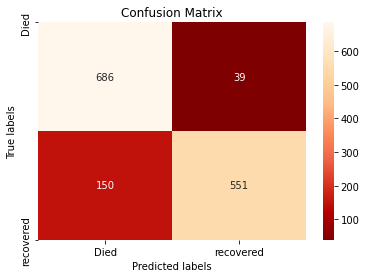

In [ ]:
X_test2=np.resize(X_test1,(1426,35,1))   #validation data  
y_test2=y_test1.to_numpy('int')    #train output
validation_x = X_test2
validation_y = y_test2
ypre=model.predict(validation_x)
pre_y=np.where(ypre>0.5, 1, 0)
accuracy = accuracy_score(validation_y, pre_y)
auc=metrics.roc_auc_score(validation_y, pre_y)
print('Accuracy: %f' % accuracy)
print('AUC: %f' % auc)
print('Classification Report')
target_names = ['Recovered', 'Died']
print(classification_report(validation_y, pre_y, target_names=target_names))
# confusion matrix
matrix = confusion_matrix(validation_y, pre_y)
print(matrix)
ax=plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax,cmap='OrRd_r', fmt='g')#annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels'); 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Died', 'recovered']); 
ax.yaxis.set_ticklabels(['Died', 'recovered']);
ax.set(yticks=[0, 2], 
       xticks=[0.5, 1.5])

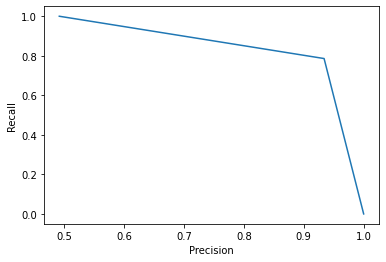

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(validation_y,pre_y)
plt.plot(precision,recall)
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()